# SI Model with constant-population demographics

Building up from the SI model without demography, we next explore the addition of basic demographics - adding a birth rate & an equivalent, age-independent mortality rate $\mu$ to keep constant total population.  The disease model remains the SI model.

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \mu I
$$

With a bit of manipulation as in the previous example, this can be worked back into the form of a generalized logistic growth differential equation
$$ \dot{I} = \beta I (1-\frac{\mu}{\beta}-\frac{I}{N})$$

With solution 
$$
\frac{Nx}{1+(\frac{Nx}{I_0}-1)e^{-\beta x t}} \\
x = (1-\frac{\mu}{\beta})
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with three components: `Susceptibility`, `Transmission`, and `Births_ConstantPop`.  Finally, we initialize with a single infection and run.  The `Susceptibility` and `Transmission` components are described in the the model with no births.  `Births_ConstantPop` strictly enforces constant population - rather than having separate, random birth and death process, births are implemented by randomly choosing an existing agent and re-initializing them as a newborn.  Births are drawn from a Poisson distribution with rate determined by parameter `cbr` (in units of births per 1000 population per year). 


### Sanity check
The first test ensures certain basic constraints are being obeyed by the model.  We confirm that at each timestep, $S_t=N_t-I_t$. 

### Scientific test
Finally, we come to the scientific test.  First, we run a basic test on a single model, and show the result matches expectation with known inputs.  Then, as before, we select a few values of $\beta$ and $\mu$, run the model, fit the outputs to the logistic equation, and compare the fitted values of the parameters to the known value.  The equation above makes it clear that attempting to fit $\beta, \mu$ and N all together will be degenerate - the logistic equation has two parameters, not three; in this case those two are the products $N x$ and $\beta x$.  Thus, we fix the total population size $N$ in the fit to focus on the more interesting $\beta$ and $\mu$ parameters.  And as before, because we are approximating continuously compounding growth, in the logistic equation, with a discrete time-step approximation, we expect the fitted values of $\beta$ to be biased slightly downward - that is, the modeled trajectory is slightly slower than the continuous-time counterpart.  This error grows as $\beta$ gets larger; the test fails if any of the fitted $\beta$ values are more than 5% away from the known values.  Furthermore, if the outbreak is seeded by only one infection, it is possible that that one infection dies prior to infecting anyone else; we therefore seed with a few infections rather than one.



In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import laser_core
import laser_generic

print(f"{np.__version__=}")
print(f"{laser_core.__version__=}")
print(f"{laser_generic.__version__=}")


np.__version__='2.2.6'
laser_core.__version__='0.6.0'
laser_generic.__version__='0.0.0'


In [12]:
import laser_generic.models.SI as SI
from laser_generic.newutils import RateMap
from laser_generic.newutils import grid

In [13]:
pop = 1e6
init_inf = 1
# scenario = pd.DataFrame(data=[["homenode", pop]], columns=["name", "population"])
latitude = 47+(36+(35/60))/60
longitude = -(122+(19+(59/60))/60)
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x, y:  pop,  origin_x=latitude, origin_y=longitude)
scenario["S"] = scenario.population - init_inf
scenario["I"] = init_inf
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.04, "cbr": 40.0})
birthrates = RateMap.from_scalar(parameters.cbr, nsteps=parameters.nticks, nnodes=1)
mortality  = RateMap.from_scalar(0.0, nsteps=parameters.nticks, nnodes=1)
model = SI.Model(scenario, parameters, birthrates=birthrates.rates, mortalityrates=mortality.rates)

model.components = [
    SI.Susceptible(model),
    SI.Infected(model),
    SI.ConstantPopVitalDynamics(model),
    SI.Transmission(model),
    ]

model.run()

/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/shapely/constructive.py:375: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)
Running Simulation: SI Model: 100%|██████████| 730/730 [00:00<00:00, 1309.74it/s]


# Sanity checks
Check that the relationships between susceptible, infected, and total population hold.  In the version with no births, we could also test that the infected = the sum of past incidence, but with births now playing a role that no longer holds.

S = N-I:  True


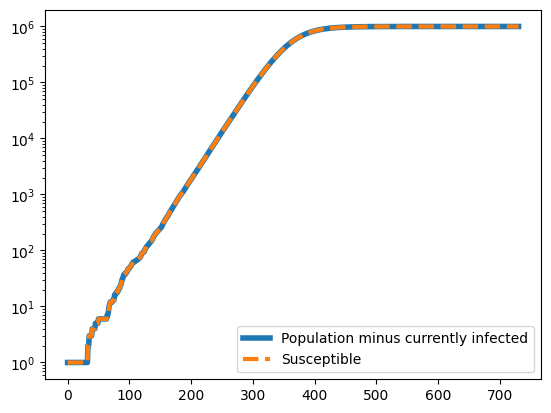

In [14]:
plt.plot(model.nodes.I.astype("int"), lw=4)
N = model.nodes.S + model.nodes.I
plt.plot(N - model.nodes.S, "--", lw=3)
plt.yscale("log")
plt.legend(["Population minus currently infected", "Susceptible", "Population minus cumulative infections (incidence)"])

print("S = N-I:  " + str(np.isclose(model.nodes.S, N - model.nodes.I).all()))

The below plot shows the model output, the expected logistic growth curve, and the expected logistic growth curve fit to the model with a free offset $t_0$ to account for stochasticity in when the outbreak takes off.  The resulting plot should show good concordance between the model output and the expected logistic equation with the known model inputs $\beta$ and population.
The goodness of this fit could be turned into a strict pass/fail test down the line.

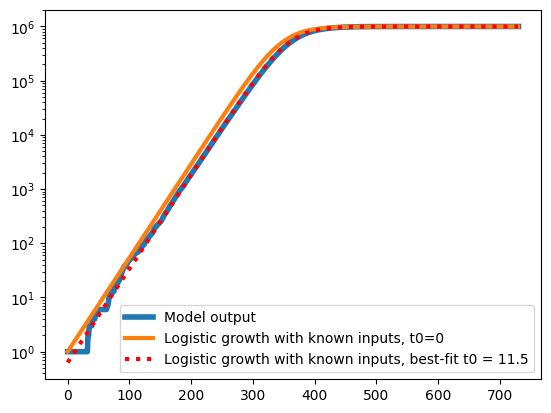

In [15]:
def SI_logistic(t, beta, popsize, cbr, t0):
    mu = (1 + cbr / 1000) ** (1 / 365) - 1
    x = 1 - mu / beta
    return popsize * x / (1 + (popsize * x - 1) * np.exp(-beta * x * (t - t0)))


t = np.arange(model.params.nticks)


def objective(t0):
    return np.sum((1 - SI_logistic(t, model.params.beta, pop, model.params.cbr, t0) / np.squeeze(model.nodes.I[1:,:])) ** 2)


result = minimize(objective, x0=10)
t0_opt = result.x[0]

plt.plot(model.nodes.I, lw=4)
plt.plot(SI_logistic(t, model.params.beta, pop, model.params.cbr, 0), lw=3)
plt.plot(SI_logistic(t, model.params.beta, pop, model.params.cbr, t0_opt), "r:", lw=3)
plt.yscale("log")
plt.legend(["Model output", "Logistic growth with known inputs, t0=0", f"Logistic growth with known inputs, best-fit t0 = {t0_opt:.1f}"])

## Scientific testing
Finally, we run the model for a range of $\beta$ & birth rate  parameters, we freely fit the model output to the logistic equation, and we compare the known input parameters against the parameters fitted from output.  

Because we are approximating continuously compounding growth by discrete-time compounding growth, we should expect the fitted $\beta$  to consistently be slightly underestimated relative to the true $\beta$ , with the relative difference growing as $\beta$  gets larger.   

In the future, we could probably compute the expected error from this approximation.  But for now, to make this a pass-fail test, we will raise a flag if the fitted parameters are more than 5% different than the known ones.

In [16]:
# %%capture
NTESTS = 10 # 10
seeds = [42 + i for i in range(NTESTS)]
pop = 1e6
nticks = 3650
betas = [0.002 + 0.005 * i for i in range(1, NTESTS+1)]
cbrs = np.random.randint(10, 120, NTESTS)
output = pd.DataFrame(columns=["seed", "beta", "cbr", "cases", "fitted_beta", "fitted_size", "fitted_t0"])
scenario = pd.DataFrame(data=[["homenode", pop]], columns=["name", "population"])

#####
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x, y:  pop,  origin_x=latitude, origin_y=longitude)
scenario["S"] = scenario.population - init_inf
scenario["I"] = init_inf
#####

for i, (seed, beta, cbr) in enumerate(zip(seeds, betas, cbrs)):

    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta, "cbr": cbr})
    birthrates = RateMap.from_scalar(parameters.cbr, nsteps=parameters.nticks, nnodes=1)
    mortality  = RateMap.from_scalar(0.0, nsteps=parameters.nticks, nnodes=1)
    model = SI.Model(scenario, parameters, birthrates=birthrates.rates, mortalityrates=mortality.rates)

    model.components = [
        SI.Susceptible(model),
        SI.Infected(model),
        SI.ConstantPopVitalDynamics(model),
        SI.Transmission(model),
        ]
    model.run(label=f"SI Model {i} of {NTESTS} (beta={beta}, cbr={cbr})")
    cases = model.nodes.I[1:, 0]
    popt, pcov = curve_fit(
        SI_logistic,
        np.arange(nticks),
        cases,
        p0=[beta * (1 + 0.1 * np.random.normal()), pop, cbr * (1 + 0.1 * np.random.normal()), 1],
        bounds=([0, pop - 1, 0, -100], [1, pop + 1, 600, 100]),
    )
    output = pd.concat(
        [
            output,
            pd.DataFrame.from_dict(
                {
                    "seed": seed,
                    "beta": beta,
                    "cbr": cbr,
                    "cases": [np.array(cases)],
                    "fitted_beta": popt[0],
                    "fitted_size": popt[1],
                    "fitted_cbr": popt[2],
                    "fitted_t0": popt[3],
                }
            ),
        ],
        ignore_index=True,
    )

/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/shapely/constructive.py:375: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)
Running Simulation: SI Model 0 of 10 (beta=0.007, cbr=67): 100%|██████████| 3650/3650 [00:02<00:00, 1266.35it/s]
/var/folders/fl/_ns4br_j2qxd92vjrgl3t4n00000gn/T/ipykernel_17218/2136715767.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat(
/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/shapely/constructive.py:375: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)
Running Simulation: SI Model 1 of 10 (beta=0.012, cbr=28): 100%|████████

(-50.0, 50.0)

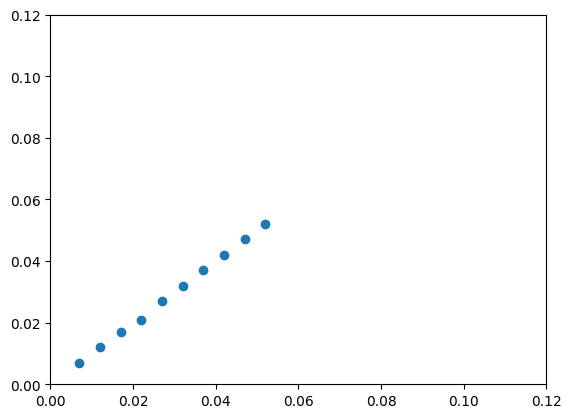

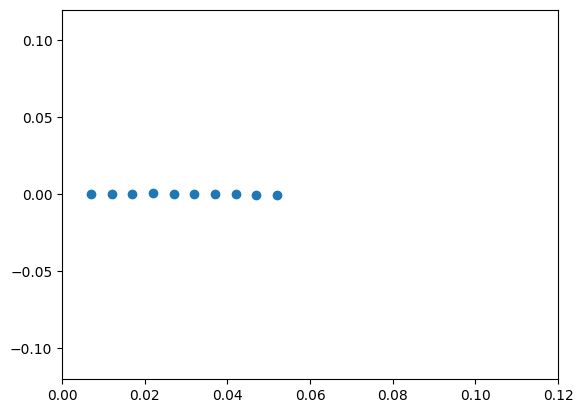

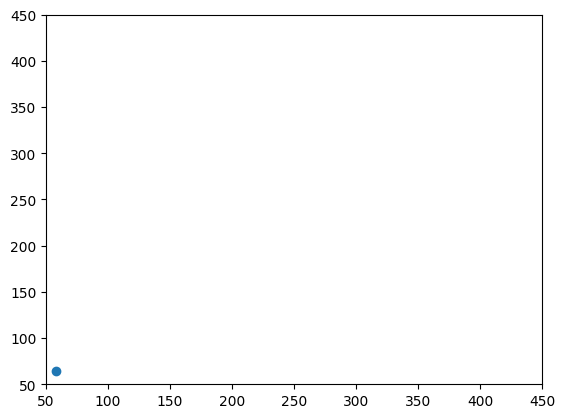

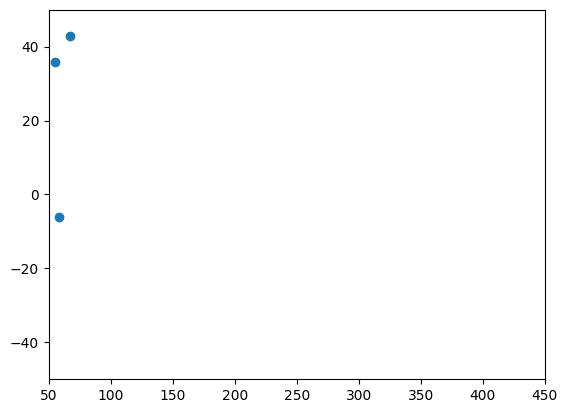

In [17]:
plt.figure()
plt.plot(output["beta"], output["fitted_beta"], "o")
plt.xlim(0, 0.12)
plt.ylim(0, 0.12)
plt.figure()
plt.plot(output["beta"], output["beta"] - output["fitted_beta"], "o")
plt.xlim(0, 0.12)
plt.ylim(-0.12, 0.12)
plt.figure()
plt.plot(output["cbr"], output["fitted_cbr"], "o")
plt.xlim(50, 450)
plt.ylim(50, 450)
plt.figure()
plt.plot(output["cbr"], output["cbr"] - output["fitted_cbr"], "o")
plt.xlim(50, 450)
plt.ylim(-50, 50)

In [18]:
print(
    "All fitted beta are within 5% of known beta: " + str(np.all(np.abs((output["beta"] - output["fitted_beta"]) / output["beta"]) < 0.05))
)
print("All fitted CBR are within 5% of known CBR: " + str(np.all(np.abs((output["cbr"] - output["fitted_cbr"]) / output["cbr"]) < 0.05)))

All fitted beta are within 5% of known beta: True
All fitted CBR are within 5% of known CBR: False


In [19]:
output

,seed,beta,cbr,cases,fitted_beta,fitted_size,fitted_t0,fitted_cbr
0,42,0.007,67,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.006993,1.000001e+06,47.998240,24.160309
1,43,0.012,28,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.012007,9.999990e+05,-83.269100,9.980618
2,44,0.017,110,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.016988,1.000001e+06,56.787824,40.049406
3,45,0.022,58,"[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.020921,1.000000e+06,1.000204,64.143524
4,46,0.027,98,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.027007,1.000000e+06,10.719214,35.207678
5,47,0.032,115,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.031988,1.000001e+06,-1.986454,41.070384
6,48,0.037,108,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...",0.036999,1.000001e+06,1.153370,38.524086
7,49,0.042,28,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.041929,1.000001e+06,0.634586,9.389643
8,50,0.047,55,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...",0.047046,1.000000e+06,29.185818,19.072557
9,51,0.052,39,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",0.052099,1.000001e+06,-10.444790,13.269673


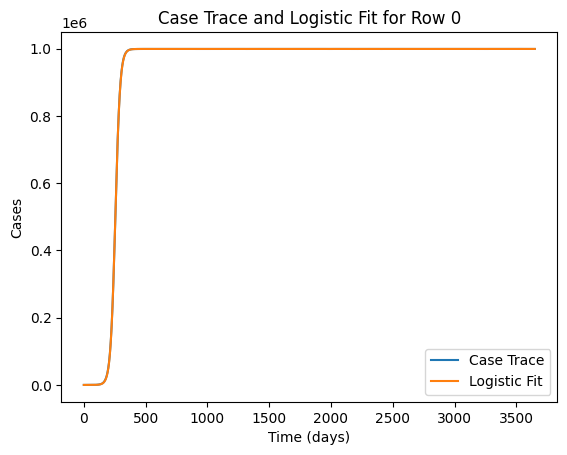

In [20]:
row = output.iloc[9]
cases_row = row["cases"]
fitted_beta = row["fitted_beta"]
fitted_size = row["fitted_size"]
fitted_cbr = row["fitted_cbr"]
fitted_t0 = row["fitted_t0"]

plt.figure()
plt.plot(cases_row, label="Case Trace")
plt.plot(SI_logistic(np.arange(nticks), fitted_beta, fitted_size, fitted_cbr, fitted_t0), label="Logistic Fit")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Cases")
plt.title("Case Trace and Logistic Fit for Row 0")
# plt.ylim(9.8e5, 1e6)
plt.show()

Just an interesting note - because I kicked the simulations off with 3 infections rather than 1 (to ensure that the initial infection doesn't die before infecting someone), we consistently get a negative fit value for t0, and one that is a larger negative value for the lowest $\beta$ values.